# EDA

## INbreast Release 1.0
<b>Link:</b> https://www.kaggle.com/datasets/ramanathansp20/inbreast-dataset
<b>Formato:</b> DICOM

- El conjunto completo de imágenes dicom se encuentra en la carpeta 'AllDICOMs'.
- El nombre del archivo incluye una identificación anónima del paciente. Por ejemplo, en el nombre de archivo '20586908_6c613a14b80a8591_MG_R_CC_ANON', '6c613a14b80a8591' es el ID del paciente que puede utilizarse para agregar DICOMs en casos y vincular dicoms con el informe médico.
- Los ROI se encuentran en el archivo xml
- El archivo INbreast.xls contiene un resumen de la base de datos, incluida la clasificación BIRADS. El campo de fecha corresponde al año y semestre (01 o 02).
- La carpeta 'MedicalReports' contiene los informes médicos asociados. El nombre del archivo es la identificación anonimizada del paciente. La fecha, cuando está presente, corresponde al año y al semestre (01 o 02).
- La carpeta 'PectoralMuscle' contiene la anotación manual del límite del músculo pectoral.

In [11]:
import pandas as pd

INbreast_metadata = pd.read_excel("D:\\Proyecto de investigacion\\INbreast Release 1.0\\INbreast.xls")
INbreast_metadata.rename(columns={"Mass ": "Mass"}, inplace=True)
#Selecciono las columnas que me muestran información relevante
df_INbreast = INbreast_metadata[["File Name", "Laterality", "View", "ACR", "Bi-Rads", "Mass", "Micros", "Distortion", "Asymmetry"]]
#Elimino las dos utlimas filas que me muestran unos totales del excel que no son necesarios
df_INbreast = df_INbreast.iloc[:-2]
#Convierto el "File Name" de float a integer para eliminar el punto decimal y luego a string
df_INbreast.loc[:, "File Name"] = df_INbreast["File Name"].astype(int).astype(str)

#Binarización de columnas
df_INbreast["Mass"] = df_INbreast["Mass"].apply(lambda x: 1 if x == 'X' else 0)
df_INbreast["Micros"] = df_INbreast["Micros"].apply(lambda x: 1 if x == 'X' else 0)
df_INbreast["Distortion"] = df_INbreast["Distortion"].apply(lambda x: 1 if x == 'X' else 0)
df_INbreast["Asymmetry"] = df_INbreast["Asymmetry"].apply(lambda x: 1 if x == 'X' else 0)

print(df_INbreast)

    File Name Laterality View ACR Bi-Rads  Mass  Micros  Distortion  Asymmetry
0    22678622          R   CC   4       1     0       0           0          0
1    22678646          L   CC   4       3     1       0           0          0
2    22678670          R  MLO   4       1     0       0           0          0
3    22678694          L  MLO   4       3     1       0           0          0
4    22614074          R   CC   2       5     1       1           0          0
..        ...        ...  ...  ..     ...   ...     ...         ...        ...
405  22613848          L  MLO   2       1     0       0           0          0
406  24055725          L  MLO   4       2     0       1           0          0
407  24055752          R  MLO   4       2     0       1           0          0
408  24055779          L   CC   4       2     0       1           0          0
409  24055806          R   CC   4       2     0       1           0          0

[410 rows x 9 columns]


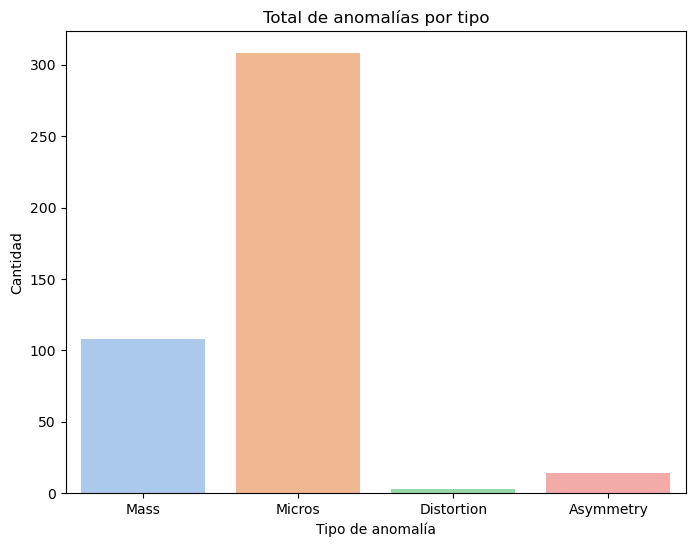

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

anomalies = ["Mass", "Micros", "Distortion", "Asymmetry"]
sums = df_INbreast[anomalies].sum()

plt.figure(figsize=(8, 6))
sns.barplot(x=sums.index, y=sums.values, palette="pastel")
plt.title("Total de anomalías por tipo")
plt.ylabel("Cantidad")
plt.xlabel("Tipo de anomalía")
plt.show()


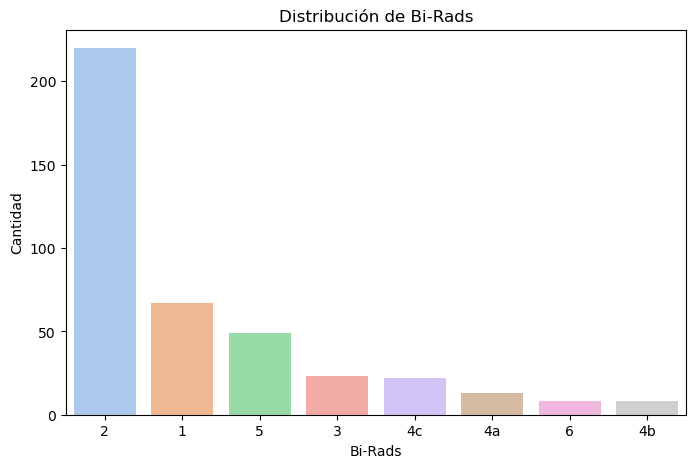

In [3]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df_INbreast, x='Bi-Rads', palette='pastel', order=df_INbreast['Bi-Rads'].value_counts().index)
plt.title('Distribución de Bi-Rads')
plt.ylabel('Cantidad')
plt.show()

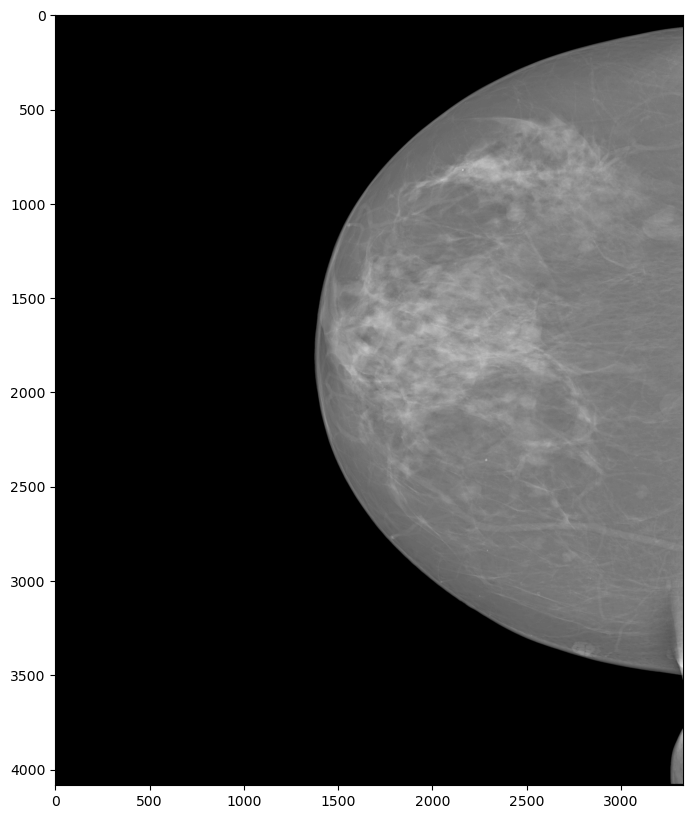

In [4]:
import pydicom

filename = "D:\\Proyecto de investigacion\\INbreast Release 1.0\\AllDICOMs\\20586908_6c613a14b80a8591_MG_R_CC_ANON.dcm"

dataset = pydicom.dcmread(filename)

if 'PixelData' in dataset:
    plt.figure(figsize=(10,10))
    plt.imshow(dataset.pixel_array, cmap="gray")
    plt.show()
else:
    print("El archivo no tiene datos de imagen.")


In [5]:
import xml.etree.ElementTree as ET

tree = ET.parse("D:\\Proyecto de investigacion\\INbreast Release 1.0\\AllXML\\20586908.xml")
root = tree.getroot()

rois_coordinates = []

for roi in root.findall(".//dict"):
    point_px_found = False
    points = []
    for child in roi:
        if point_px_found and child.tag == "array":
            for string_element in child.findall("string"):
                x, y = map(float, string_element.text.strip('()').split(', '))
                points.append((x, y))
            rois_coordinates.append(points)
            break
        if child.tag == "key" and child.text == "Point_px":
            point_px_found = True


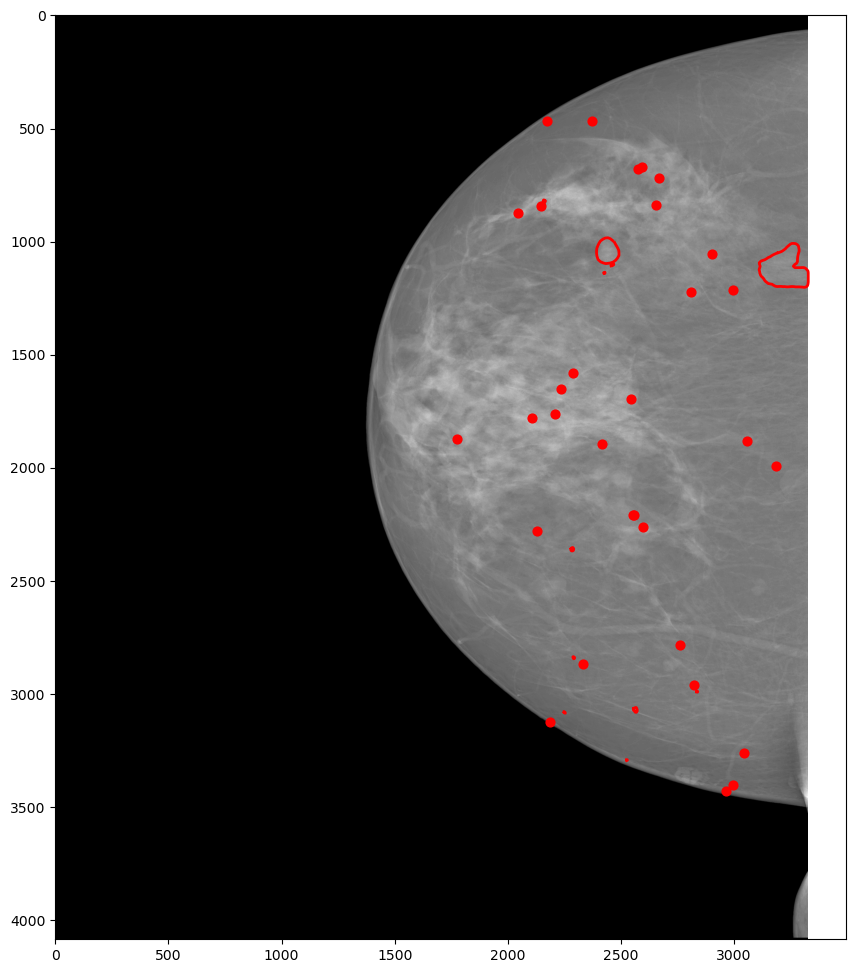

In [6]:
import numpy as np

image_array = dataset.pixel_array

fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.imshow(image_array, cmap="gray")

for roi in rois_coordinates:
    roi_array = np.array(roi)
    if len(roi) == 1:
        ax.scatter(roi_array[0, 0], roi_array[0, 1], color='red', s=40)
    else:
        ax.plot(roi_array[:, 0], roi_array[:, 1], 'r-', linewidth=2)
        
plt.show()

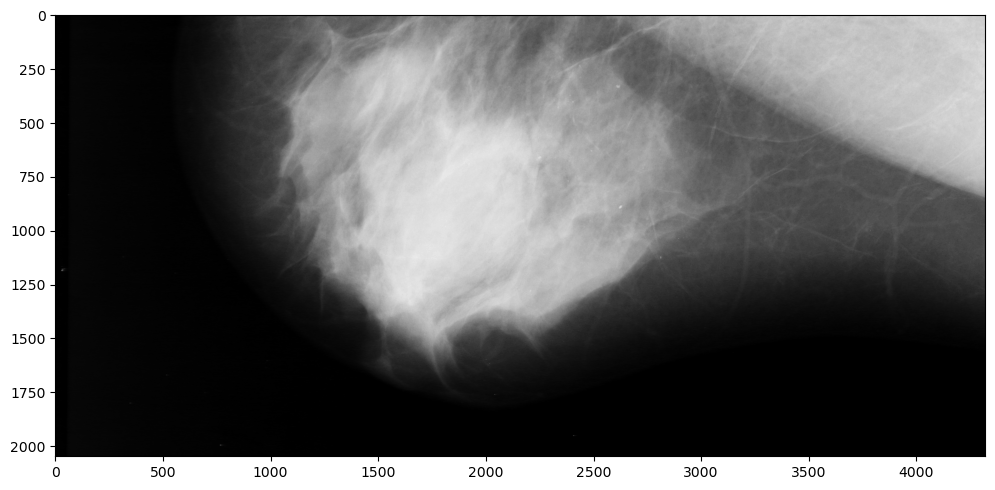

In [7]:
from PIL import Image

image_MIAS = Image.open("D:\\Proyecto de investigacion\\MIASDBv1.21\\mdb001lm.pgm")

image_MIAS_array = np.array(image_MIAS)
plt.figure(figsize=(12,12))
plt.imshow(image_MIAS_array, cmap='gray')
plt.show()

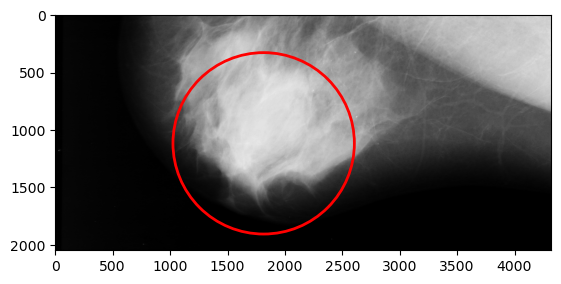

<Figure size 1200x1200 with 0 Axes>

In [8]:
from matplotlib.patches import Circle

fig, ax = plt.subplots()

ax.imshow(image_MIAS_array, cmap='gray')

circle = Circle((1815, 1116), 790, fill=False, color='red', linewidth=2)

ax.add_patch(circle)

plt.figure(figsize=(12,12))
plt.show()

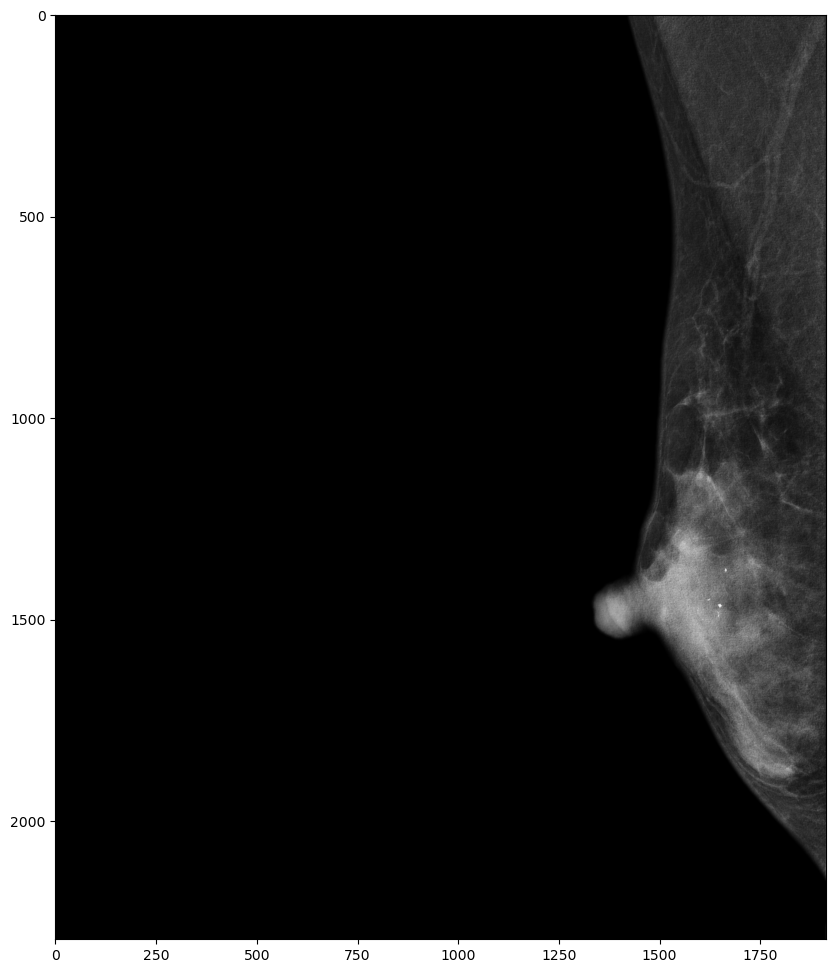

In [9]:
cmmd_filepath = ("D:\\Proyecto de investigacion\\chinese mammography\\manifest-1616439774456\\CMMD\\D1-0001\\07-18-2010-NA-NA-79377\\1.000000-NA-70244\\1-2.dcm")

cmmd_dataset = pydicom.dcmread(cmmd_filepath)

if 'PixelData' in cmmd_dataset:
    plt.figure(figsize=(12,12))
    plt.imshow(cmmd_dataset.pixel_array, cmap="gray")  # Colormap apropiado para radiografías
    plt.show()
else:
    print("El archivo no tiene datos de imagen.")

In [10]:
xml_INbreast = pd.read_xml("D:\\Proyecto de investigacion\\INbreast Release 1.0\\AllXML\\20586908.xml")
xml_INbreast

,key,array
0,Images,NaN
